In [113]:
#In the last file I had multiple libs that I import twice
import nltk
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from collections import Counter
import os
import glob
import re
import string

%matplotlib inline

## Importing Data Into DataFrames

#### Convote

In [66]:
fil = open("../data/convote_v1.1/data_stage_one/development_set/052_400011_0327014_DON.txt", 'r')
statinfo = os.stat("../data/convote_v1.1/data_stage_one/development_set/052_400011_0327014_DON.txt")
#putting all of the convote stage one data into a pandas dataframe
path = "../data/convote_v1.1/data_stage_one/training_set/"
convote = pd.DataFrame([[1, 2, 'stuff']], columns=['Party', 'Size', 'Speech'])
i = 0
for filename in glob.glob(os.path.join(path, '*.txt')):
    tempFil = open(filename, 'r')
    indicator = (filename[-7:-4])
    statinfo = os.stat(filename)
    s = int(statinfo.st_size)
    party = 0
    #democrat = 0, republican = 1
    if indicator[0] == 'D':
        party = 0
    else:
        party = 1
    convote.loc[i] = ([party, s, tempFil.read()])
    i += 1  
convote.head()

,Party,Size,Speech
0,0,1788,"mr. speaker , i rise in opposition to the rule..."
1,0,60,"mr. speaker , i rise for a constitutional poin..."
2,0,1496,"mr. speaker , the resolution we are preparing ..."
3,0,141,"mr. speaker , consistent with the oath of offi..."
4,0,52,"mr. speaker , on that i demand the yeas and na..."


## Searching For Features
Looking for any statistically significant features in the data sets. 

### Current Datasets Tested
1. Convote

In [92]:
from nltk.corpus import cmudict
d = cmudict.dict()
def nsyl(word):
    return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]] 

In [129]:
def getTotalAverages(df, x):
    """
    This function goes through the pandas dataframe to calculate the averages of the total dataframe.
    These averages include, length of speeches, total democrats, total republicans
    df: a pandas dataframe
    x: speech part of dataframe
    """
    totalDem, totalRepub, averageWordCount, averageDemWord, averageRepubWord, avgDemSyll, avgRepubSyll = 0, 0, [], [], [], [], []
    
    for index, row in df.iterrows():
        if row["Party"] == 0: 
            speech = re.sub(r'[^\w\s]','',row[x])
            speech1 = speech.split()
            totalDem += 1
            speechlen = len(speech1)
            averageWordCount.append(speechlen)
            averageDemWord.append(speechlen)
            tempsyll = 0
            for word in speech1: 
                l = len(word)
                tempsyll += l
            avgDemSyll.append(tempsyll/speechlen)
        else: 
            speech = re.sub(r'[^\w\s]','',row[x])
            speech1 = speech.split()
            speechlen = len(speech1)
            totalRepub += 1
            speechlen = len(speech1)
            averageWordCount.append(speechlen)
            averageRepubWord.append(speechlen)
            tempsyll = 0
            for word in speech1: 
                l = len(word)
                tempsyll += l
            avgRepubSyll.append(tempsyll/speechlen)
            
    print("Total Democrats in Dataframe: ", totalDem)
    print("Total Republicans in Dataframe: ", totalRepub)
    print("Avg syll dem: ", (np.average(avgDemSyll), (np.std(avgDemSyll))))
    print("Avg Repub Syll: ", (np.average(avgRepubSyll), (np.std(avgRepubSyll))))
    print("Average Word count of speeches in Dataframe: ", (np.average(averageWordCount)))
    print("Average Word count of Democratic speeches in Dataframe:", np.average(averageDemWord), np.std(averageDemWord))
    print("Average Word count of Republican speeches in Dataframe:", np.average(averageRepubWord), np.std(averageRepubWord))
    
    #plotting these, might have to modifiy this based on the data
    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    axs[0].bar(['Democrat', 'Republican'], [totalDem, totalRepub], align='center', alpha=0.5)
    axs[0].set_title('Total # of Speakers by Party')
    axs[1].bar(['Total', 'Democratic', 'Republican'], 
                   [np.average(averageWordCount), np.average(averageDemWord), np.average(averageRepubWord)],
                   align='center', alpha=0.5)
    axs[1].set_title('Average # of Words by a Speaker by Party')
    return averageWordCount, averageDemWord, averageRepubWord

Total Democrats in Dataframe:  2848
Total Republicans in Dataframe:  2812
Avg syll dem:  (4.650038903486936, 0.4846549212160515)
Avg Repub Syll:  (4.613814506444291, 0.4480307709880089)
Average Word count of speeches in Dataframe:  249.39628975265018
Average Word count of Democratic speeches in Dataframe: 283.60568820224717 457.4458163821257
Average Word count of Republican speeches in Dataframe: 214.74893314366997 337.7751692889713


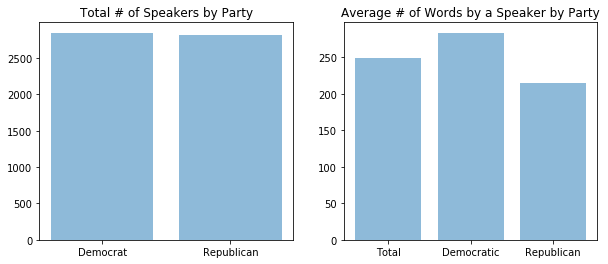

In [130]:
speechAvg = getTotalAverages(convote, "Speech")

In [69]:
def showDist(distList):
    fig, axs = plt.subplots(ncols=len(distList), figsize=(24, 8))
    for i in range(len(distList)): 
        sns.distplot(distList[i], ax=axs[i]).set_title('Distribution of Data')

c:\users\taber fisher\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

c:\users\taber fisher\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



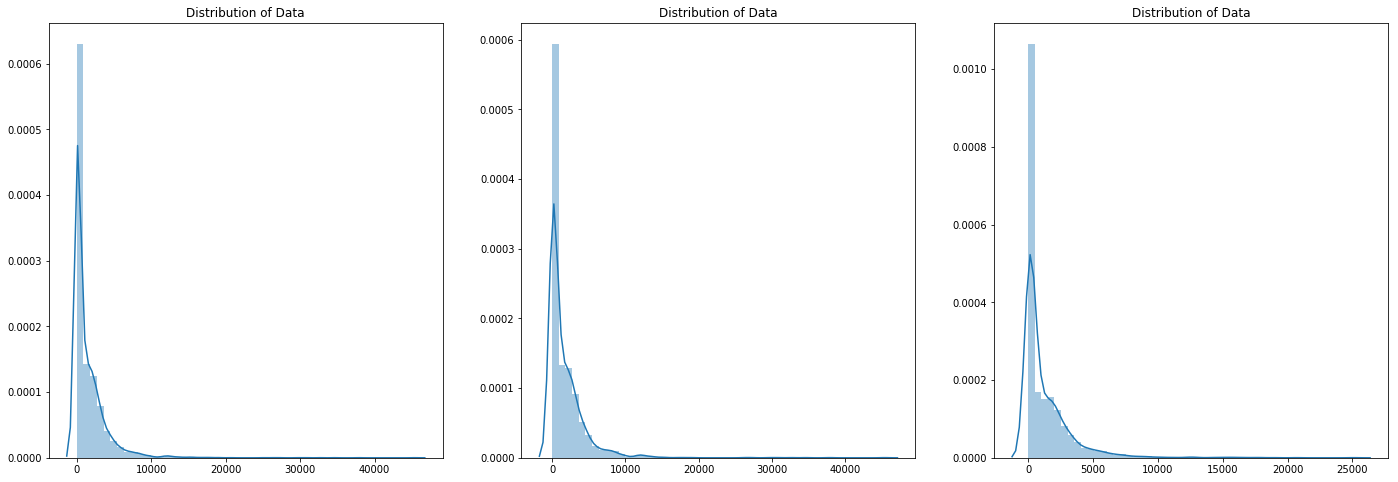

In [70]:
showDist(speechAvg)

In [73]:
import textatistic
def getReadingScores(df):
    #flesch_reading_ease
    #flesch_kincaid_grade
    dem_reading_ease = []
    repub_reading_ease = []
    dem_grade = []
    repub_grade = []
    for index, row in df.iterrows():
        text = row["Speech"]
        if row["Party"] == 0: 
            #dems
            try:
                dem_reading_ease.append(textatistic.flesch_score(text))
                dem_grade.append(textatistic.fleschkincaid_score(text))
            except: 
                print("divide by zero for some reason")
        else: 
            #repub
            try:
                repub_reading_ease.append(textatistic.flesch_score(text))
                repub_grade.append(textatistic.fleschkincaid_score(text))
            except: 
                print("divide by zero for some reason")
    print("Democratic Reading Ease (Mean, Standard Distorbution):", np.average(dem_reading_ease), np.std(dem_reading_ease))
    print("Republican Reading Ease (Mean, Standard Distorbution):", np.average(repub_reading_ease), np.std(repub_reading_ease))
    print("Democratic Grade (Mean, Standard Distorbution):", np.average(dem_grade), np.std(dem_grade))
    print("Republican Grade (Mean, Standard Distorbution):", np.average(repub_grade), np.std(repub_grade))
    return dem_reading_ease, repub_reading_ease, dem_grade, repub_grade

In [74]:
gradeEase = getReadingScores(convote)

divide by zero for some reason
Democratic Reading Ease (Mean, Standard Distorbution): 74.75426399246321 15.457257180767261
Republican Reading Ease (Mean, Standard Distorbution): 75.43456774262533 14.1917353344682
Democratic Grade (Mean, Standard Distorbution): 6.130663542349957 3.655064746986331
Republican Grade (Mean, Standard Distorbution): 5.875519269277647 3.4231386397010337


c:\users\taber fisher\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

c:\users\taber fisher\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



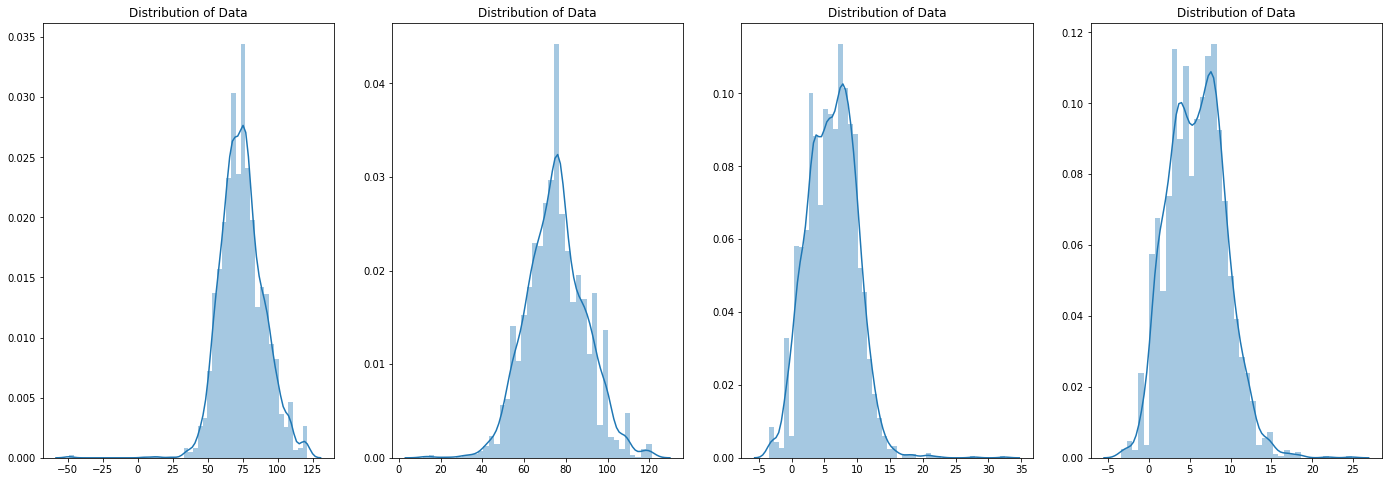

In [75]:
showDist(gradeEase)

### Sentiment Analysis

In [76]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Taber
[nltk_data]     Fisher\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [77]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def nltk_sentiment(sentence):
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [78]:
def getSentiment(df):
    #flesch_reading_ease
    #flesch_kincaid_grade
    dem_sent_neg = []
    dem_sent_pos = []
    dem_sent_neu = []
    dem_sent_compound = []
    repub_sent_neg = []
    repub_sent_pos = []
    repub_sent_neu = []
    repub_sent_compound = []
    for index, row in df.iterrows():
        text = row["Speech"]
        if row["Party"] == 0: 
            #dems
            tempdic = (nltk_sentiment(text))
            if len(tempdic) > 0:
                dem_sent_neg.append((tempdic['neg']))
                dem_sent_pos.append((tempdic['pos']))
                dem_sent_neu.append((tempdic['neu']))
                dem_sent_compound.append((tempdic['compound']))
        else: 
            #repub
            tempdic = (nltk_sentiment(text))
            if len(tempdic) > 0:
                repub_sent_neg.append((tempdic['neg']))
                repub_sent_pos.append((tempdic['pos']))
                repub_sent_neu.append((tempdic['neu']))
                repub_sent_compound.append((tempdic['compound']))
                
    dem = [np.average(dem_sent_neg), np.average(dem_sent_pos), np.average(dem_sent_neu), np.average(dem_sent_compound)]
    repub = [np.average(repub_sent_neg), np.average(repub_sent_pos), np.average(repub_sent_neu), np.average(repub_sent_compound)]
    print("Democratic Sentiment Negitive (Mean, Standard Distorbution):", np.average(dem_sent_neg), np.std(dem_sent_neg))
    print("Democratic Sentiment Positive (Mean, Standard Distorbution):", np.average(dem_sent_pos), np.std(dem_sent_pos))
    print("Democratic Sentiment Neutral (Mean, Standard Distorbution):", np.average(dem_sent_neu), np.std(dem_sent_neu))
    print("Democratic Sentiment Compound (Mean, Standard Distorbution):", np.average(dem_sent_compound), np.std(dem_sent_compound))
    print("Republican Sentiment Negitive (Mean, Standard Distorbution):", np.average(repub_sent_neg), np.std(repub_sent_neg))
    print("Republican Sentiment Positive (Mean, Standard Distorbution):", np.average(repub_sent_pos), np.std(repub_sent_pos))
    print("Republican Sentiment Neutral (Mean, Standard Distorbution):", np.average(repub_sent_neu), np.std(repub_sent_neu))
    print("Republican Sentiment Compound (Mean, Standard Distorbution):", np.average(repub_sent_compound), np.std(repub_sent_compound))
    categorical_1 = ['Neg', 'Pos', 'Neu', 'Comp']
    colors        = ['blue', 'red']
    numerical = [dem, repub]
    number_groups = len(numerical) 
    bin_width = 1.0/(number_groups+1)
    fig, ax = plt.subplots(figsize=(6,6))
    for i in range(number_groups):
        ax.bar(x=np.arange(len(categorical_1)) + i*bin_width, 
               height=numerical[i],
               width=bin_width,
               color=colors[i],
               align='center')
    ax.set_xticks(np.arange(len(categorical_1)) + number_groups/(2*(number_groups+1)))
    # number_groups/(2*(number_groups+1)): offset of xticklabel
    ax.set_xticklabels(categorical_1)
    ax.legend(['Dem', 'Repub'], facecolor='w')
    ax.set_title("Averages of Sentiment Across Parties")
    plt.show()
    return dem_sent_neg, dem_sent_pos, dem_sent_neu, dem_sent_compound, repub_sent_neg, repub_sent_pos, repub_sent_neu, repub_sent_compound


Democratic Sentiment Negitive (Mean, Standard Distorbution): 0.05117661516853933 0.06151305630846255
Democratic Sentiment Positive (Mean, Standard Distorbution): 0.0882313904494382 0.09106116468658791
Democratic Sentiment Neutral (Mean, Standard Distorbution): 0.860602176966292 0.11161052595381755
Democratic Sentiment Compound (Mean, Standard Distorbution): 0.23623167134831463 0.6331821038788821
Republican Sentiment Negitive (Mean, Standard Distorbution): 0.03834886201991465 0.0597198317941018
Republican Sentiment Positive (Mean, Standard Distorbution): 0.08448115220483642 0.0916885033711998
Republican Sentiment Neutral (Mean, Standard Distorbution): 0.8771810099573257 0.11208518412974212
Republican Sentiment Compound (Mean, Standard Distorbution): 0.3273715504978663 0.5680561811891601


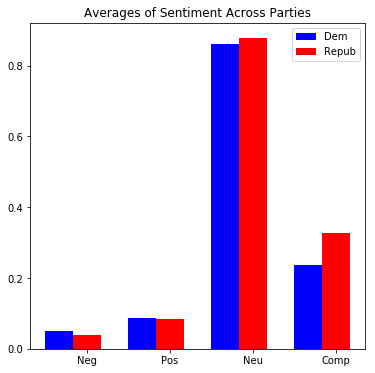

In [79]:
sentimentScores = getSentiment(convote)

##### What do this numbers mean? 

The Vader sentiment analyzer that we are using scores documents based off the percentage positive or negitive.  For example if a document comes back with a dictionary that looks like score = {'neg': .2, 'pos': .6, 'neu': .2, 'comp': .65} This means that the document is rated as 20% negetive, 60% posititve, 20% neutral. The compound rating is a normalized numbers between -1 and 1 for negitive and positive respectivly. 

For this data it looks as though on average most speeches are around 80% neural and the compound score is slighly positive. 

c:\users\taber fisher\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

c:\users\taber fisher\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



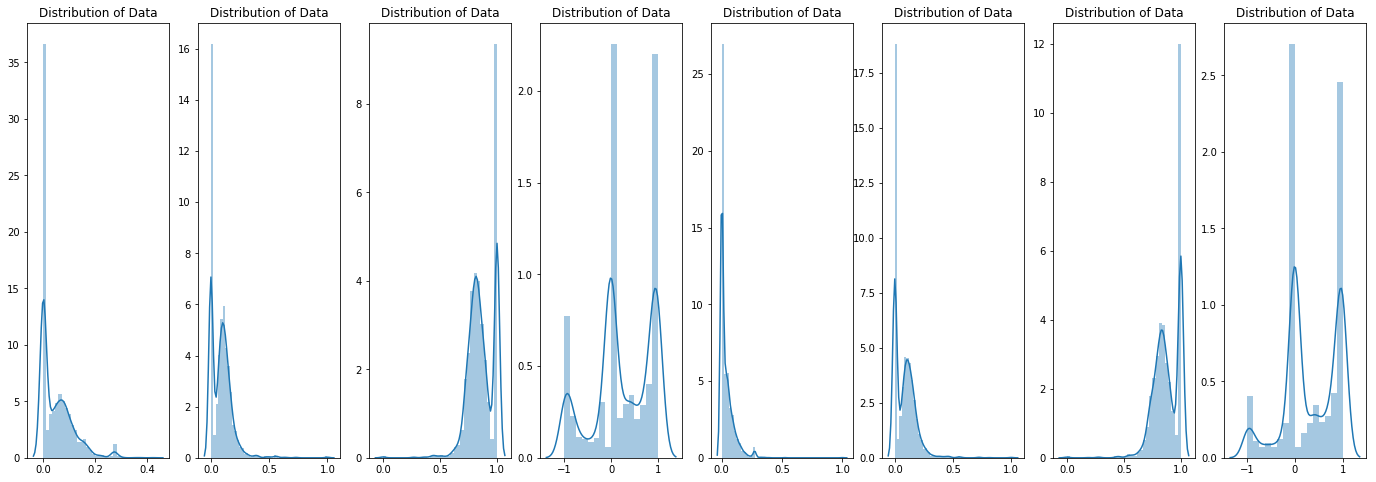

In [80]:
showDist(sentimentScores)

### Is the data normal? 

From the distrobution plots it does not look like we can treat this data as normal, instead we need to figure out a non-paramentric way to test the significance

### Is the Data significant? (p < .1 or better p < .05)

In [81]:
from scipy.stats import mannwhitneyu

print("Convote P-values:")
#Compound Sentiment
stat, p = mannwhitneyu(sentimentScores[3], sentimentScores[7])
print("Compound Sentiment p-value:", p)

#Negitive Sentiment
stat, p = mannwhitneyu(sentimentScores[0], sentimentScores[4])
print("Negitive Sentiment p-value:", p)

#Positive Sentiment
stat, p = mannwhitneyu(sentimentScores[1], sentimentScores[5])
print("Positive Sentiment p-value:", p)

#Neutral Sentiment
stat, p = mannwhitneyu(sentimentScores[2], sentimentScores[6])
print("Neutral Sentiment p-value:", p)

#Reading Ease
stat, p = mannwhitneyu(gradeEase[0], gradeEase[1])
print("Reading Ease p-value:", p)

#Reading Grade
stat, p = mannwhitneyu(gradeEase[2], gradeEase[3])
print("Grade Level p-value:", p)

#speechAvg
stat, p = mannwhitneyu(speechAvg[1], speechAvg[2])
print("Average words in speeches p-value:", p)

Convote P-values:
Compound Sentiment p-value: 2.934648349961977e-06
Negitive Sentiment p-value: 1.8016387459936536e-18
Positive Sentiment p-value: 0.030174628845434648
Neutral Sentiment p-value: 2.6533538441600253e-10
Reading Ease p-value: 0.005397628912187551
Grade Level p-value: 0.0011787612782884708
Average words in speeches p-value: 6.888994138617783e-08


Text(0.5, 1.0, 'P-values')

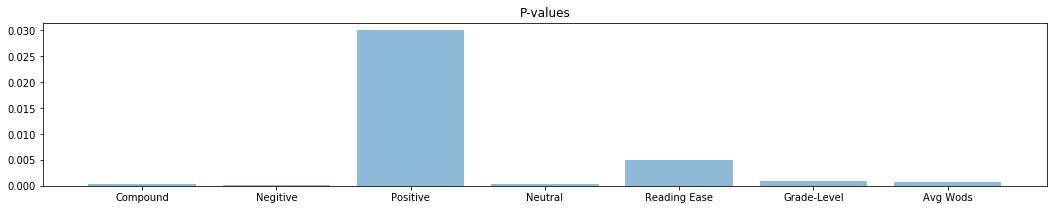

In [169]:
pVal = [.00029, .00018, .03, .00027, .005, .001, .00069]
pnames = ['Compound','Negitive', 'Positive', 
          'Neutral', 'Reading Ease', 'Grade-Level', 'Avg Wods']

fig, ax = plt.subplots(figsize=(18,3))
ax.bar(pnames, pVal, align='center', alpha=0.5)
ax.set_title('P-values')

## Collecting More features about the data
1. SAGE scores (N-grams)
2. Average word length (Syllables per word)
3. BOW model
4. Topic modeling (LDA)

## SAGE scores (with n-grams)

## Topic Modeling LDA

### Politician Social Media

There is a slight problem with this dataset, they only list if something is partisian or not, they do not list from what party (bias) it comes from, for the main purpose of this data set I will just look at if partisian vs non-partisan comments have different scores. 

In [131]:
politicalSoc = pd.read_csv('../data/political_social_media.csv',  encoding = "ISO-8859-1")
politicalSoc.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,orig__golden,audience_gold,bias_gold,bioid,embed,id,label,message_gold,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),NaN,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,...,NaN,NaN,NaN,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0,support,...,NaN,NaN,NaN,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),NaN,twitter,Please join me today in remembering our fallen...
3,766192487,False,finalized,1,8/4/15 21:08,national,1.0,neutral,1.0,policy,...,NaN,NaN,NaN,C000880,"<blockquote class=""twitter-tweet"" width=""450"">...",2.98528E+17,From: Michael Crapo (Senator from Idaho),NaN,twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,False,finalized,1,8/4/15 21:26,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,U000038,"<blockquote class=""twitter-tweet"" width=""450"">...",4.07643E+17,From: Mark Udall (Senator from Colorado),NaN,twitter,.@amazon delivery #drones show need to update ...


In [132]:
print(politicalSoc.iloc[0]["text"])
print(politicalSoc.iloc[2]["text"])
print(politicalSoc.iloc[4]["text"])

RT @nowthisnews: Rep. Trey Radel (R- #FL) slams #Obamacare. #politics https://t.co/zvywMG8yIH
Please join me today in remembering our fallen heroes and honoring the men and women currently in military service for their sacrifices.
.@amazon delivery #drones show need to update law to promote #innovation &amp; protect #privacy. My #UAS bill does that: http://t.co/l9ta5SKq6u


In [133]:
def  clean_tweet(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

In [134]:
cleanSoc = clean_tweet(politicalSoc, "text")
cleanSoc.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,orig__golden,audience_gold,bias_gold,bioid,embed,id,label,message_gold,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),NaN,twitter,rep trey radel r fl slams obamacare politics
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,...,NaN,NaN,NaN,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,video obamacare full of higher costs and bro...
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0,support,...,NaN,NaN,NaN,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),NaN,twitter,please join me today in remembering our fallen...
3,766192487,False,finalized,1,8/4/15 21:08,national,1.0,neutral,1.0,policy,...,NaN,NaN,NaN,C000880,"<blockquote class=""twitter-tweet"" width=""450"">...",2.98528E+17,From: Michael Crapo (Senator from Idaho),NaN,twitter,1st step toward senate debate on leahycrapo ...
4,766192488,False,finalized,1,8/4/15 21:26,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,U000038,"<blockquote class=""twitter-tweet"" width=""450"">...",4.07643E+17,From: Mark Udall (Senator from Colorado),NaN,twitter,delivery drones show need to update law to pr...


In [135]:
print(politicalSoc.iloc[1]["text"])
print(politicalSoc.iloc[2]["text"])
print(politicalSoc.iloc[4]["text"])

video  obamacare  full of higher costs and broken promises 
please join me today in remembering our fallen heroes and honoring the men and women currently in military service for their sacrifices
 delivery drones show need to update law to promote innovation amp protect privacy my uas bill does that 


In [136]:
classes = cleanSoc['bias']
print(classes.value_counts())

neutral     3689
partisan    1311
Name: bias, dtype: int64


In [137]:
stop_words = set(stopwords.words('english'))
cleanSoc['text'] = cleanSoc['text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))
cleanSoc['text'] = cleanSoc['text'].apply(lambda x: ' '.join(term for term in x.split() if term not in ['ûªs', 'û', 'ûªt', 'r', 'en', 'fl', 'p', 'va', 'amp', 'icymi', 'th', 'pm', 'hours', 'u']))

In [138]:
print(cleanSoc.iloc[0]["text"])
print(cleanSoc.iloc[2]["text"])
print(cleanSoc.iloc[4]["text"])

rep trey radel slams obamacare politics
please join today remembering fallen heroes honoring men women currently military service sacrifices
delivery drones show need update law promote innovation protect privacy uas bill


In [139]:
def getTotalAverages(df, x):
    """
    This function goes through the pandas dataframe to calculate the averages of the total dataframe.
    These averages include, length of speeches, total democrats, total republicans
    df: a pandas dataframe
    x: speech part of dataframe
    """
    totalBias, totalNeutral, averageWordCount, averagePartWord, averageNeutWord = 0, 0, [], [], []
    
    for index, row in df.iterrows():
        if row["bias"] == "partisan": 
            totalBias += 1
            averageWordCount.append(len(row[x]))
            averagePartWord.append(len(row[x]))
        else: 
            totalNeutral += 1
            averageWordCount.append(len(row[x]))
            averageNeutWord.append(len(row[x]))
            
    print("Total Partision Comments in Dataframe: ", totalBias)
    print("Total Neutral Comments in Dataframe: ", totalNeutral)
    print("Average Word count of socail media in Dataframe: ", (np.average(averageWordCount)))
    print("Average Word count of bias speeches in Dataframe:", np.average(averagePartWord), np.std(averagePartWord))
    print("Average Word count of Neutral speeches in Dataframe:", np.average(averageNeutWord), np.std(averageNeutWord))
    
    #plotting these, might have to modifiy this based on the data
    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    axs[0].bar(['Partisan', 'Neutral'], [totalBias, totalNeutral], align='center', alpha=0.5)
    axs[0].set_title('Total # of Comments by Bais')
    axs[1].bar(['Total', 'Partisan', 'Neutral'], 
                   [np.average(averageWordCount), np.average(averagePartWord), np.average(averageNeutWord)],
                   align='center', alpha=0.5)
    axs[1].set_title('Average # of Words by a Speaker by Bias')
    return averageWordCount, averagePartWord, averageNeutWord

Total Partision Comments in Dataframe:  1311
Total Neutral Comments in Dataframe:  3689
Average Word count of socail media in Dataframe:  133.0746
Average Word count of bias speeches in Dataframe: 147.31884057971016 271.88519855532564
Average Word count of Neutral speeches in Dataframe: 128.01246950393062 164.04948660183132


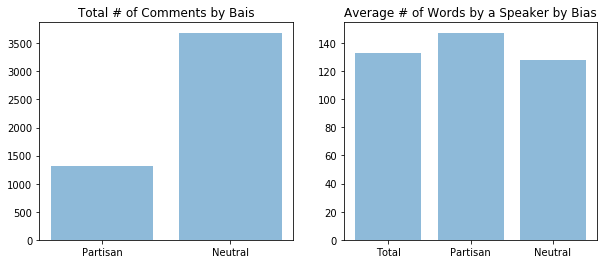

In [140]:
socAvg = getTotalAverages(cleanSoc, "text")

c:\users\taber fisher\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

c:\users\taber fisher\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



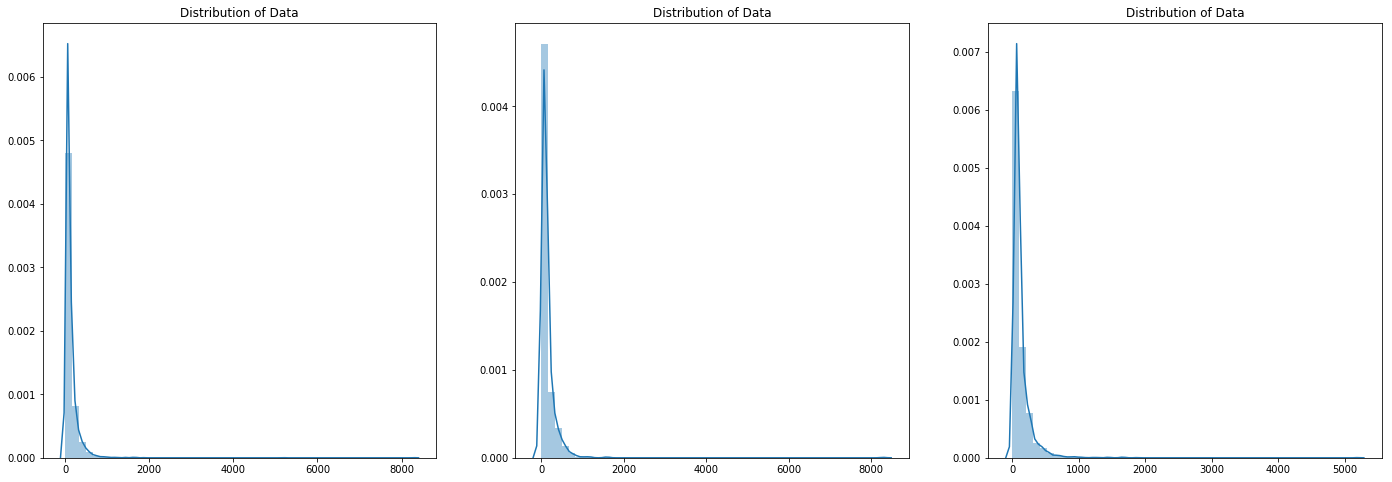

In [141]:
showDist(socAvg)

In [142]:
def getSentiment(df):
    #flesch_reading_ease
    #flesch_kincaid_grade
    dem_sent_neg = []
    dem_sent_pos = []
    dem_sent_neu = []
    dem_sent_compound = []
    repub_sent_neg = []
    repub_sent_pos = []
    repub_sent_neu = []
    repub_sent_compound = []
    for index, row in df.iterrows():
        text = row["text"]
        if row["bias"] == "partisan": 
            #dems
            tempdic = (nltk_sentiment(text))
            if len(tempdic) > 0:
                dem_sent_neg.append((tempdic['neg']))
                dem_sent_pos.append((tempdic['pos']))
                dem_sent_neu.append((tempdic['neu']))
                dem_sent_compound.append((tempdic['compound']))
        else: 
            #repub
            tempdic = (nltk_sentiment(text))
            if len(tempdic) > 0:
                repub_sent_neg.append((tempdic['neg']))
                repub_sent_pos.append((tempdic['pos']))
                repub_sent_neu.append((tempdic['neu']))
                repub_sent_compound.append((tempdic['compound']))
                
    dem = [np.average(dem_sent_neg), np.average(dem_sent_pos), np.average(dem_sent_neu), np.average(dem_sent_compound)]
    repub = [np.average(repub_sent_neg), np.average(repub_sent_pos), np.average(repub_sent_neu), np.average(repub_sent_compound)]
    print("Partiasn Sentiment Negitive (Mean, Standard Distorbution):", np.average(dem_sent_neg), np.std(dem_sent_neg))
    print("Partiasn Sentiment Positive (Mean, Standard Distorbution):", np.average(dem_sent_pos), np.std(dem_sent_pos))
    print("Partiasn Sentiment Neutral (Mean, Standard Distorbution):", np.average(dem_sent_neu), np.std(dem_sent_neu))
    print("Partiasn Sentiment Compound (Mean, Standard Distorbution):", np.average(dem_sent_compound), np.std(dem_sent_compound))
    print("Neutral Sentiment Negitive (Mean, Standard Distorbution):", np.average(repub_sent_neg), np.std(repub_sent_neg))
    print("Neutral Sentiment Positive (Mean, Standard Distorbution):", np.average(repub_sent_pos), np.std(repub_sent_pos))
    print("Neutral Sentiment Neutral (Mean, Standard Distorbution):", np.average(repub_sent_neu), np.std(repub_sent_neu))
    print("Neutral Sentiment Compound (Mean, Standard Distorbution):", np.average(repub_sent_compound), np.std(repub_sent_compound))
    categorical_1 = ['Neg', 'Pos', 'Neu', 'Comp']
    colors        = ['blue', 'red']
    numerical = [dem, repub]
    number_groups = len(numerical) 
    bin_width = 1.0/(number_groups+1)
    fig, ax = plt.subplots(figsize=(6,6))
    for i in range(number_groups):
        ax.bar(x=np.arange(len(categorical_1)) + i*bin_width, 
               height=numerical[i],
               width=bin_width,
               color=colors[i],
               align='center')
    ax.set_xticks(np.arange(len(categorical_1)) + number_groups/(2*(number_groups+1)))
    # number_groups/(2*(number_groups+1)): offset of xticklabel
    ax.set_xticklabels(categorical_1)
    ax.legend(['Partisan', 'Neutral'], facecolor='w')
    ax.set_title("Averages of Sentiment Across Bias")
    plt.show()
    return dem_sent_neg, dem_sent_pos, dem_sent_neu, dem_sent_compound, repub_sent_neg, repub_sent_pos, repub_sent_neu, repub_sent_compound

Partiasn Sentiment Negitive (Mean, Standard Distorbution): 0.11699847444698702 0.13818118418240244
Partiasn Sentiment Positive (Mean, Standard Distorbution): 0.16856750572082382 0.16548821462745475
Partiasn Sentiment Neutral (Mean, Standard Distorbution): 0.7121411136536995 0.19115113347988244
Partiasn Sentiment Compound (Mean, Standard Distorbution): 0.10939267734553776 0.49765636129331237
Neutral Sentiment Negitive (Mean, Standard Distorbution): 0.060809704526972076 0.11513288186232967
Neutral Sentiment Positive (Mean, Standard Distorbution): 0.23929167796150722 0.20149012660191892
Neutral Sentiment Neutral (Mean, Standard Distorbution): 0.6969086473298997 0.21071719571978798
Neutral Sentiment Compound (Mean, Standard Distorbution): 0.34009972892382756 0.46302175064109763


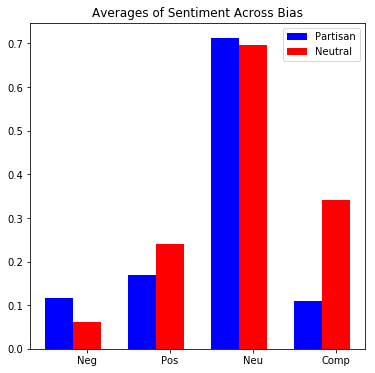

In [143]:
sentimentScores = getSentiment(cleanSoc)

c:\users\taber fisher\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

c:\users\taber fisher\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



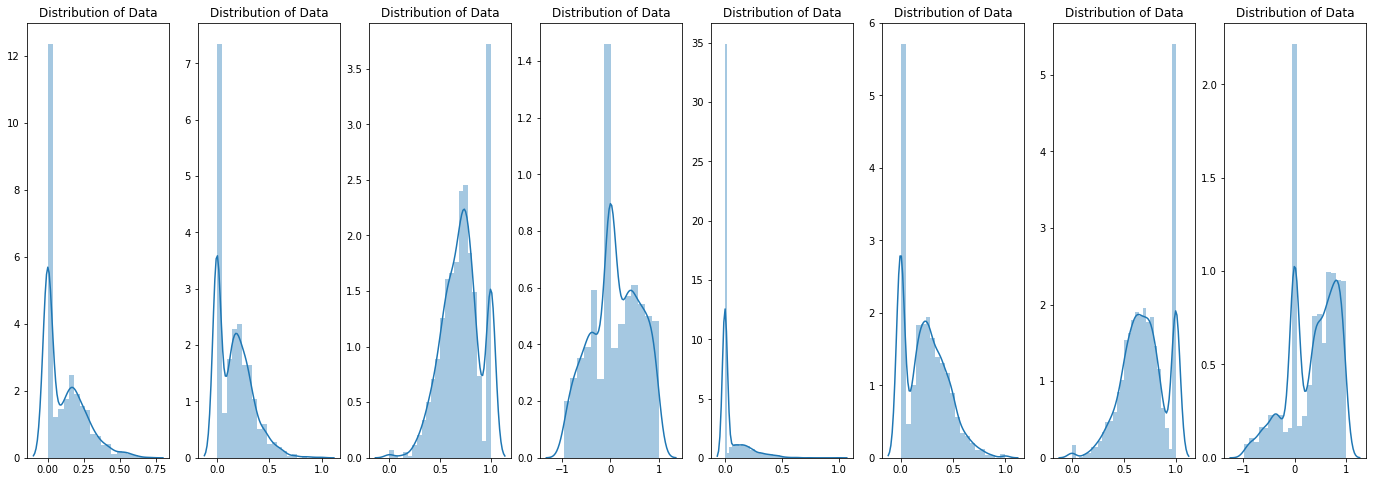

In [144]:
showDist(sentimentScores)

In [145]:
print("Social Media P-values:")
#Compound Sentiment
stat, p = mannwhitneyu(socAvg[1], socAvg[2])
print("Average Word p-value:", p)

#Compound Sentiment
stat, p = mannwhitneyu(sentimentScores[3], sentimentScores[7])
print("Compound Sentiment p-value:", p)

#Negitive Sentiment
stat, p = mannwhitneyu(sentimentScores[0], sentimentScores[4])
print("Negitive Sentiment p-value:", p)

#Positive Sentiment
stat, p = mannwhitneyu(sentimentScores[1], sentimentScores[5])
print("Positive Sentiment p-value:", p)

#Neutral Sentiment
stat, p = mannwhitneyu(sentimentScores[2], sentimentScores[6])
print("Neutral Sentiment p-value:", p)

Social Media P-values:
Average Word p-value: 8.177567705149212e-05
Compound Sentiment p-value: 2.8033060766855133e-47
Negitive Sentiment p-value: 1.9382792737149504e-58
Positive Sentiment p-value: 1.297024499814971e-28
Neutral Sentiment p-value: 0.007751693275430354


In [146]:
nltk_sentiment(cleanSoc.iloc[1]["text"])

{'compound': -0.128, 'neg': 0.29, 'neu': 0.467, 'pos': 0.243}

In [147]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## 2nd Stage of Model

First we wanted to look at a selected dataset of articles and run our model on the sentences in them and see if we could plot all of the sentenies in 3D space to see if they cluster together

In [148]:
sentenceValues = np.random.randint(20, size=(3, 500))

trace1 = go.Scatter3d(
    x=sentenceValues[0],
    y=sentenceValues[1],
    z=sentenceValues[2],
    mode='markers',
    marker=dict(
        size=3,              # set color to an array/list of desired values
        colorscale=[[0.0, 'rgb(165,0,38)'], [1.0, 'rgb(49,54,149)']],
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

In [149]:
#creating fake vectors out of data
def create_input_vectors(df, col_title):
    final = []
    for index, row in df.iterrows():
        temp = [0] * 5
        tempdic = (nltk_sentiment(row[col_title]))
        if row["Party"] == 0: 
            temp[0] = len(row[col_title])
            temp[1] = tempdic['neg']
            temp[2] = tempdic['pos']
            temp[3] = tempdic['neu']
            temp[4] = 0
        else: 
            temp[0] = len(row[col_title])
            temp[1] = tempdic['neg']
            temp[2] = tempdic['pos']
            temp[3] = tempdic['neu']
            temp[4] = 1
        final.append(temp)
        
    return final

In [150]:
final = create_input_vectors(convote,"Speech")

In [151]:
fakeVec=np.array([np.array(xi) for xi in final])

In [152]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [153]:
print(fakeVec.shape)

(5660, 5)


In [154]:
X, Y = np.split(fakeVec, [4], axis=1)

In [155]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.80)

## Create Multiple Different Models
1. Simple Dense NN
2. Logistic regression
3. SVM
4. Nearest Neighbors
5. Naive Bayes
6. Decision Trees
7. AdaBoost
8. Graident Tree Boosting
9. Forest of Randomized Trees

### Simple Dense NN

In [156]:
model = Sequential()
hidden_layers = 7
nodes_per_layer = 50
model.add(Dense(nodes_per_layer, input_dim=4, kernel_initializer='normal', activation='relu'))
for i in range(hidden_layers):
        model.add(Dense(nodes_per_layer, activation='relu'))
        
model.add(Dense(1,  activation='relu'))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae'])
model.fit(X_train, Y_train, epochs=10, batch_size=1)
print(model.summary())

Epoch 1/10
1132/1132 [==============================] - 7s 7ms/step - loss: 0.4965 - acc: 0.5035 - mean_absolute_error: 0.4965
Epoch 2/10
1132/1132 [==============================] - 4s 3ms/step - loss: 0.4965 - acc: 0.5035 - mean_absolute_error: 0.4965
Epoch 3/10
1132/1132 [==============================] - 3s 3ms/step - loss: 0.4965 - acc: 0.5035 - mean_absolute_error: 0.4965
Epoch 4/10
1132/1132 [==============================] - 3s 2ms/step - loss: 0.4965 - acc: 0.5035 - mean_absolute_error: 0.4965
Epoch 5/10
1132/1132 [==============================] - 3s 2ms/step - loss: 0.4965 - acc: 0.5035 - mean_absolute_error: 0.4965
Epoch 6/10
1132/1132 [==============================] - 3s 2ms/step - loss: 0.4965 - acc: 0.5035 - mean_absolute_error: 0.4965
Epoch 7/10
1132/1132 [==============================] - 3s 2ms/step - loss: 0.4965 - acc: 0.5035 - mean_absolute_error: 0.4965
Epoch 8/10
1132/1132 [==============================] - 3s 2ms/step - loss: 0.4965 - acc: 0.5035 - mean_absolut

In [158]:
y_pred_nn = model.predict(X_test)
mean_squared_error(Y_test[:, 0], y_pred_nn[:, 0])

0.49690812720848054

### Logistic Regression

In [180]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='lbfgs')
logreg.fit(X_train, np.ravel(Y_train,order='C'))
predictions = logreg.predict(X_test)
score = logreg.score(X_test, Y_test)
print(score)

0.5300353356890459


## Random Forest for Features

In [174]:
from sklearn.ensemble import RandomForestClassifier
rfc_feature_estimator = RandomForestClassifier(n_estimators=100, 
                                               random_state=21)
rfc_feature_estimator.fit(X_train, np.ravel(Y_train,order='C'))
print(rfc_feature_estimator.feature_importances_)

[0.4086103  0.17450911 0.20733263 0.20954795]


Text(0.5, 1.0, 'Most Important Feature')

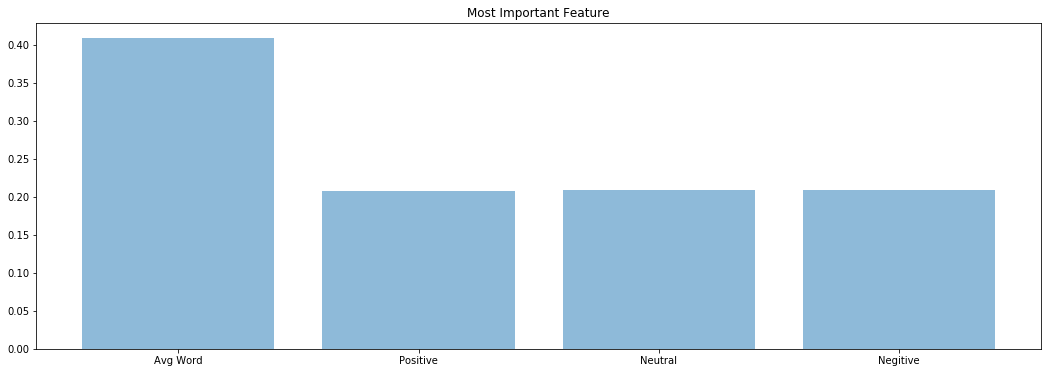

In [183]:
randNum = [0.4086103, 0.20733263, 0.20954795, 0.20954795]
randNames = ["Avg Word", "Positive", "Neutral", "Negitive"]

fig, ax = plt.subplots(figsize=(18,6))
ax.bar(randNames, randNum, align='center', alpha=0.5)
ax.set_title('Most Important Feature')

In [185]:
from sklearn import svm
clf = svm.SVC(gamma='scale')
clf.fit(X_train, np.ravel(Y_train,order='C'))
predictions = clf.predict(X_test)
score = clf.score(X_test, Y_test)
print(score)

0.5061837455830389


In [194]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train, np.ravel(Y_train,order='C'))
predictions = model.predict(X_test)
score = model.score(X_test, Y_test)
print(score)

0.5106007067137809


In [195]:
from sklearn import tree
tr = tree.DecisionTreeClassifier()
tr.fit(X_train, np.ravel(Y_train,order='C'))
predictions = tr.predict(X_test)
score = tr.score(X_test, Y_test)
print(score)

0.5183303886925795
